## Image Center, Edges, Keypoints

In [1]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

Cloning into 'cs4250'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 65 (delta 19), reused 53 (delta 11), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation
from google.colab.patches import cv2_imshow

%matplotlib inline

In [3]:
def load_image_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [4]:
def load_image_gray_normalized(image_path):
    return load_image_gray(image_path).astype('float32')/255.

In [5]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y

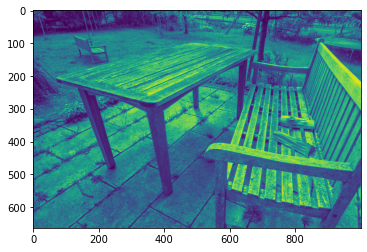

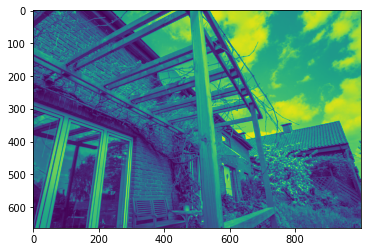

In [6]:
ueb311 = load_image_gray_normalized('/content/cs4250/data/exercise_3/ueb311.jpg')
ueb312 = load_image_gray('/content/cs4250/data/exercise_3/ueb312.jpg')

plt.imshow(ueb311)
plt.show()
plt.imshow(ueb312)
plt.show()


### Edge Detection


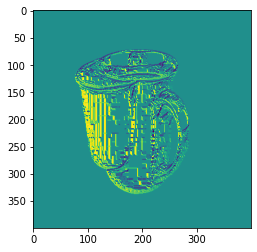

In [7]:
# load image
ueb32 = load_image_gray('/content/cs4250/data/exercise_3/ueb32.jpg')
#cv2_imshow(ueb32)

# smooth image
ueb32_smooth = cv2.filter2D(ueb32,-1,5)
#cv2_imshow(ueb32_smooth)

# compute and show gradient images 
# make images comparable
d_x, d_y = gradient(ueb32_smooth)

# compute gradient magnitude
d_x_mag = np.absolute(d_x)
d_y_mag = np.absolute(d_y)

# compute an angle image that should be in range [-180,+180]
angle = np.arctan2(d_y,d_x)

# show angles only for real edges
plt.imshow(angle)


### Canny Edge Detector


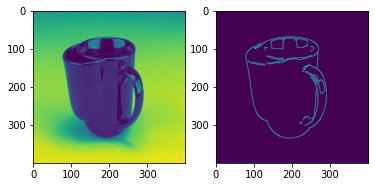

In [8]:
# load image
img = load_image_gray("/content/cs4250/data/exercise_3/ueb32.jpg")
#img = np.load("/content/cs4250/data/exercise_3/ueb331.npy")
img_ = np.uint8(img)
# compute magnitude of gradient image
# apply canny
edges = cv2.Canny(img_,100,200)

# compare results
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(edges)


### Key Point Detection


In [18]:
def find_local_max(keypoints, thres=1e-6, k=3):
    kernel = np.ones((k, k))
    kernel[k//2, k//2] = 0
    local_max = keypoints > thres + dilation(keypoints, kernel)

    return local_max

In [19]:
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)

    ax.plot(row, col, 'r.')

In [24]:
def key_points_structure(image, alpha, sigma=.1):
    # image parameters
    
    # 0. filter with Gaussian kernel with sigma
    img_blur = cv2.GaussianBlur(image,(0,0),sigma)

    # 1. partial derivatives
    d_x, d_y = gradient(img_blur)

    # 2. product images
    K = np.zeros(image.shape)
    K_minus_H = K.copy()
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          Ixx = d_x[i,j]*d_x[i,j]
          Ixy = d_x[i,j]*d_y[i,j]
          Iyx = d_y[i,j]*d_x[i,j]
          Iyy = d_y[i,j]*d_y[i,j]
          temp = np.block([[Ixx, Ixy],[Iyx, Iyy]])

          # 3. filter with gaussian kernel with sigma = 1
          J = cv2.GaussianBlur(temp,(0,0),sigmaX=1)

          # 4. compute invarians for J
          k = np.linalg.det(J)
          h = np.trace(J)
          
          K[i,j] = k
          K_minus_H[i,j] = k - alpha*h*h

    # return K, K_minus_H
    return K, K_minus_H

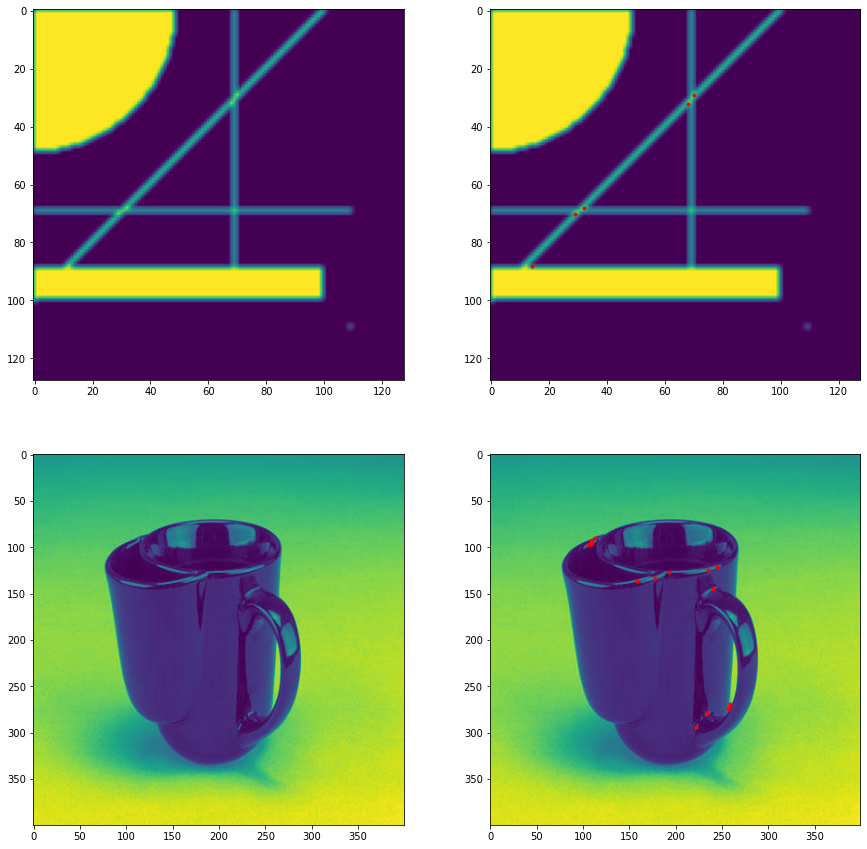

In [25]:
# define alpha, sigma, and k
alpha = 0.1

# load images
ueb331 = np.load('/content/cs4250/data/exercise_3/ueb331.npy')
ueb332 = load_image_gray_normalized('/content/cs4250/data/exercise_3/ueb332.jpg')

# extract keypoints
keypoints_K_1, keypoints_K_minus_H_1 = key_points_structure(ueb331, alpha)
keypoints_K_2, keypoints_K_minus_H_2  = key_points_structure(ueb332, alpha)

'''
_, ax = plt.subplots(2, 2, figsize=(15, 15))
ax[0][0].plot(keypoints_K_1)
ax[0][1].plot( keypoints_K_minus_H_1)
ax[1][0].plot(keypoints_K_2)
ax[1][1].plot( keypoints_K_minus_H_2)
#plt.show()
'''

# show found keypoints (K, K_minus_H) for both images
# example
_, ax = plt.subplots(2, 2, figsize=(15, 15))
local_max = find_local_max(keypoints_K_1)
ax[0][0].imshow(ueb331)
plot_marks(local_max, ax[0][0])

local_max = find_local_max(keypoints_K_minus_H_1)
ax[0][1].imshow(ueb331)
plot_marks(local_max, ax[0][1])

local_max = find_local_max(keypoints_K_2)
ax[1][0].imshow(ueb332)
plot_marks(local_max, ax[1][0])

local_max = find_local_max(keypoints_K_minus_H_2)
ax[1][1].imshow(ueb332)
plot_marks(local_max, ax[1][1])
plt.show()